In [1]:
import numpy as np; import pandas as pd 
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text
from sklearn.multioutput import MultiOutputRegressor
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
import torch; from sklearn.tree import _tree
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
import joblib 
from sklearn.model_selection import cross_val_score

In [2]:
min_max = {}
building_id = 1 

min_max['sen_hou'] = [0,24]
min_max['temp_OA'] = [-20,40]
min_max['rh_OA'] = [0,100]
min_max['Temp_mean_p0'] = [15,30]; min_max['Temp_mean_m1'] = [15,30]
min_max['sen_hou'] = [0,24]
min_max['hir_sol'] = [0,700] 

if building_id == 1: 
    data = '0_Data/Case_1/comb_data.csv'
    min_max["hvac_dem_tot"] = [0,6020] #1  #kW 
    min_max['appliances_pow'] = [0,42] #1 #kW
    min_max['elec_lights'] = [0,70]   #1 #kW
    min_max['Occ'] = [0,3300]
    scale_delta, scale_hvac = 200 , 200
elif building_id == 6:
    data = '0_Data/Case_6/comb_data.csv'
    min_max["hvac_dem_tot"] = [0,1620] #6  #kW 
    min_max['appliances_pow'] = [0,160] #6 #kW
    min_max['elec_lights'] = [0,190]   #6 #kW
    min_max['Occ'] = [0,250]
    scale_delta, scale_hvac = 600 , 200
      

min_max['u_heat_stp'] = [15,25] 
min_max['u_cool_stp'] = [20,30] 
min_max['delta_T'] = [0,1] 
min_max['Stp_n'] = [0,1] 
min_max['mode'] = [0,1] 
min_max['rtp'] = [0.05,0.3]

def plot_feature_importances(importances, feature_names, actual_feature_names, title_fontsize=14, label_fontsize=12, tick_fontsize=10,cutoff_percentage=0.95,location="feature_importances.jpg"):
    # Convert importances to percentages
    importances_percentage = np.array(importances) * 100

    # Sort features and importances
    sorted_indices = np.argsort(importances_percentage)[::-1]
    sorted_feature_names = [feature_names[i] for i in sorted_indices]
    sorted_importances = [importances_percentage[i] for i in sorted_indices]


    sorted_actual_feature_names = [actual_feature_names[i] for i in sorted_indices]
    
    # Calculate cumulative importance and find the cutoff for the specified percentage
    cumulative_importances = np.cumsum(sorted_importances)
    cutoff_index = np.where(cumulative_importances >= cutoff_percentage * 100)[0][0]
    
    # Plotting the sorted feature importances
    plt.figure(figsize=(10, 6))
    plt.bar(sorted_feature_names, sorted_importances)
    
    # Offset the cutoff line by adding 0.5
    plt.axvline(x=cutoff_index + 0.5, color='r', linestyle='--', label=f"{cutoff_percentage*100:.0f}% Cumulative Importance")

    features_below_cutoff = sorted_actual_feature_names[:cutoff_index]

    ax = plt.gca()  # Get the current axes  

    # Add a background color
    ax.set_facecolor('lightgray')  # You can change 'lightgray' to any color you prefer

    # Add a grid
    ax.grid(color='white', linestyle='--', linewidth=0.5) 


    # Save these features to a text file
    with open("features_below_cutoff.txt", "w") as file:
        for feature in features_below_cutoff:
            file.write(f"{feature}\n")
    
    plt.title("Feature Importances", fontsize=title_fontsize)
    plt.ylabel("Importance (%)", fontsize=label_fontsize)  # Updated y-label
    plt.xlabel("Features", fontsize=label_fontsize)
    plt.xticks(rotation=0, fontsize=tick_fontsize)
    plt.yticks(fontsize=tick_fontsize)
    plt.legend()
    plt.tight_layout()
    plt.savefig(location, dpi=500)
    plt.show()


In [3]:
states = np.load('states.npy')
actions = np.load('actions.npy')

In [7]:
states[0]

array([0.        , 0.56950919, 0.6       , 0.5       , 0.1       ,
       0.2       , 0.9       , 1.        , 0.9       , 0.46509315,
       0.843018  , 0.13294642, 0.22615807])

In [4]:
df_l = pd.DataFrame(states, columns=[f'feature_{i}' for i in range(1, states.shape[1] + 1)])
df_l.rename(columns={'feature_1': 'Temp_mean_p0',
                   'feature_2': 'Temp_mean_m1',
                   'feature_3': 'sen_hou',
                   'feature_4': 'temp_OA_0',
                   'feature_5': 'temp_OA_1',
                   'feature_6': 'rh',
                   'feature_7': 'rtp_0',
                   'feature_8': 'rtp_1',
                   'feature_9': 'rtp_2',
                   'feature_10': 'rtp_3',
               #     'feature_11': 'rtp_4',
               #     'feature_12': 'rtp_5',
               #     'feature_13': 'rtp_6'                  
                   }, inplace=True)

In [5]:
df_r = pd.DataFrame(actions, columns=[f'feature_{i}' for i in range(1, actions.shape[1] + 1)])
df_r.rename(columns={'feature_1': 'action_1',
                   'feature_2': 'action_2',                 
                   }, inplace=True)

df_n = pd.concat([df_l,df_r],axis=1)

df_n

,Temp_mean_p0,Temp_mean_m1,sen_hou,temp_OA_0,temp_OA_1,rh,rtp_0,rtp_1,rtp_2,rtp_3,action_1,action_2
0,0.688981,0.326327,0.6,0.904598,0.779562,0.7,1.114486,1.126827,0.790387,0.628328,0.000000,0.155433
1,0.736525,0.326188,0.8,0.932482,0.672384,1.0,0.741154,0.615747,0.249948,0.219026,0.000000,0.144182
2,0.513411,0.735901,0.3,0.883113,0.701722,0.1,0.393915,0.587211,0.517780,0.491509,0.000457,0.058288
3,0.599482,0.576264,0.0,0.890381,0.837156,0.1,0.339844,0.264075,0.274803,0.322132,0.555493,0.314588
4,0.508451,0.317845,0.1,0.913261,0.975369,0.0,0.196983,0.348307,0.329340,0.368892,0.509887,0.386573
...,...,...,...,...,...,...,...,...,...,...,...,...
299995,0.275884,0.641410,0.7,0.902998,0.958006,1.0,0.813925,0.870184,0.612456,0.461993,0.555416,0.327256
299996,0.593452,0.630249,0.4,0.603598,0.656186,0.3,0.471249,0.465845,0.609694,0.656870,0.136930,0.134156
299997,0.489285,0.427579,0.6,0.685698,0.843211,0.8,1.495635,0.810902,1.023688,0.684390,0.679113,0.473996
299998,0.698182,0.859120,0.7,0.983638,0.970266,1.0,1.114065,0.772900,0.557055,0.699362,0.063167,0.158671


In [6]:
feature_names = ['Temp_mean_p0','Temp_mean_m1','sen_hou','temp_OA_0','temp_OA_1','rh','rtp_0','rtp_1','rtp_2','rtp_3']
pred_names = ['action_1','action_2']

min_max_key = {}
min_max_key['Temp_mean_p0'] = 'Temp_mean_p0'
min_max_key['Temp_mean_m1'] = 'Temp_mean_m1'
min_max_key['sen_hou'] = 'sen_hou'
min_max_key['temp_OA_0'] = 'temp_OA'
min_max_key['temp_OA_1'] = 'Temp_mean_p0'
min_max_key['rh'] = 'rh_OA'
min_max_key['rtp_0'] = 'rtp'
min_max_key['rtp_1'] = 'rtp'
min_max_key['rtp_2'] = 'rtp'
min_max_key['rtp_3'] = 'rtp'
# min_max_key['rtp_4'] = 'rtp'
# min_max_key['rtp_5'] = 'rtp'
# min_max_key['rtp_6'] = 'rtp'

min_max_key['action_1'] = 'u_heat_stp'
min_max_key['action_2'] = 'u_cool_stp'


In [7]:
keys = feature_names+pred_names 
df=df_n[:]

for key in keys:
    df[key] = df_n[key]*(min_max[min_max_key[key]][1]-min_max[min_max_key[key]][0]) + min_max[min_max_key[key]][0]

In [183]:
df.head()

,Temp_mean_p0,Temp_mean_m1,sen_hou,temp_OA_0,temp_OA_1,rh,rtp_0,rtp_1,rtp_2,rtp_3,action_1,action_2
0,25.334713,19.894901,14.4,34.275888,26.693427,70.0,0.328622,0.331707,0.247597,0.207082,15.000000,21.554335
1,26.047880,19.892815,19.2,35.948925,25.085755,100.0,0.235288,0.203937,0.112487,0.104756,15.000000,21.441818
2,22.701162,26.038522,7.2,32.986762,25.525831,10.0,0.148479,0.196803,0.179445,0.172877,15.004570,20.582876
3,23.992227,23.643964,0.0,33.422873,27.557346,10.0,0.134961,0.116019,0.118701,0.130533,20.554928,23.145878
4,22.626760,19.767675,2.4,34.795637,29.630532,0.0,0.099246,0.137077,0.132335,0.142223,20.098867,23.865730


In [99]:
df_n.head()

,Temp_mean_p0,Temp_mean_m1,sen_hou,temp_OA_0,temp_OA_1,rh,rtp_0,rtp_1,rtp_2,rtp_3,action_1,action_2
0,1.0,0.0,0.6,0.0,0.7,0.6,1.307989,1.195762,0.991253,0.485434,0.000000,0.026336
1,0.9,0.0,0.9,0.2,0.0,0.5,0.341932,0.205798,0.259262,0.187441,0.002387,0.001423
2,1.0,0.5,0.3,0.7,0.3,0.4,0.233708,0.466562,0.417765,0.463202,0.000311,0.010209
3,0.8,0.3,0.3,0.1,0.6,0.3,0.289081,0.308909,0.490294,0.449759,0.007409,0.069802
4,1.0,0.3,0.5,0.0,0.2,0.6,0.860857,0.811796,1.240027,1.260213,0.000515,0.039523


In [182]:
with open("features_below_cutoff.txt", "r") as file:
    sel_feature_names = [line.strip() for line in file.readlines()]

sel_feature_names

['Temp_mean_p0', 'sen_hou']

In [8]:
X_n= df_n[feature_names]

y_n2= df_n[['action_2']]
y_n1= df_n[['action_1']]


X= df[feature_names]
y_act2= df[['action_2']]
y_act1= df[['action_1']]


In [9]:
tree_regressor_act1 = DecisionTreeRegressor(
    max_depth=8,           # Maximum depth of the tree
    min_samples_split=10,   # Minimum number of samples required to split an internal node
    min_samples_leaf=1,
    criterion = 'squared_error' ,  
      # Minimum number of samples required to be at a leaf node
)  

tree_regressor_act2 = DecisionTreeRegressor(
    max_depth=18,           # Maximum depth of the tree
    min_samples_split=2,   # Minimum number of samples required to split an internal node
    min_samples_leaf=1,
    # splitter = 'best',
    # max_features = "sqrt",
    criterion = 'friedman_mse',   # Minimum number of samples required to be at a leaf node
    # min_impurity_decrease = 0.000001,
)  

# Fit the model to the training data
tree_regressor_act2.fit(X, y_act2)

print ("completed training 1")

# Fit the model to the training data
tree_regressor_act1.fit(X, y_act1)


y_pred_act1 = tree_regressor_act1.predict(X)
y_pred_act2 = tree_regressor_act2.predict(X)

mse_act1 = mean_squared_error(y_act1, y_pred_act1)
mse_act2 = mean_squared_error(y_act2, y_pred_act2)

mae_act1 = mean_absolute_error(y_act1, y_pred_act1)
mae_act2 = mean_absolute_error(y_act2, y_pred_act2)

print (mse_act1)
print (mse_act2)
print ()

print (mae_act1)
print (mae_act2)

joblib.dump(tree_regressor_act1, 'tree_regressor_act1.pkl')
joblib.dump(tree_regressor_act2, 'tree_regressor_act2.pkl')

completed training 1
1.441242294445273
0.2815511096810283

0.7635869960876227
0.20924737764417883


['tree_regressor_act2.pkl']

In [ ]:
param_grid = {
    'criterion': ['squared_error', 'friedman_mse'],  # adjusted for regression
    'splitter': ['best', 'random'],
    'max_depth': [3, 5, 7],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [2, 4, 6],
    'max_features': ['sqrt', 'log2'],
    'max_leaf_nodes': [10, 20],
    'min_impurity_decrease': [0.01, 0.05]
}

# Assuming you've set up your regression dataset as X_train, y_train, etc.
grid_search_act1 = GridSearchCV(DecisionTreeRegressor(), param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search_act2 = GridSearchCV(DecisionTreeRegressor(), param_grid, cv=5, scoring='neg_mean_squared_error')

grid_search_act1.fit(X, y_act1)

print ("completed training 1")
grid_search_act2.fit(X, y_act2)

y_pred_act1 = tree_regressor_act1.predict(X)
y_pred_act2 = tree_regressor_act2.predict(X)

In [16]:
best_tree_act1 = grid_search_act1.best_estimator_
best_tree_act2 = grid_search_act2.best_estimator_

joblib.dump(best_tree_act1, 'best_tree_act1.pkl')
joblib.dump(best_tree_act2, 'best_tree_act2.pkl')


NameError: name 'grid_search_act1' is not defined

In [92]:
# y_pred_act1 = best_tree_act1.predict(X)
# y_pred_act2 = best_tree_act2.predict(X)

# best_mse_act1 = mean_squared_error(y_act1, y_pred_act1)
# best_mse_act2 = mean_squared_error(y_act2, y_pred_act2)

# best_mae_act1 = mean_absolute_error(y_act1, y_pred_act1)
# best_mae_act2 = mean_absolute_error(y_act2, y_pred_act2)

# print (best_mse_act1)
# print (best_mse_act2)
# print ()

# print (best_mae_act1)
# print (best_mae_act2)

In [97]:
importances_act2

array([0.42532631, 0.09555046, 0.07799006, 0.05614206, 0.03944903,
       0.05386808, 0.06386269, 0.05986955, 0.06349152, 0.06445024])

In [10]:
importances_act1 = tree_regressor_act1.feature_importances_
importances_act2 = tree_regressor_act2.feature_importances_

# importances_act1 = best_tree_act1.feature_importances_
# importances_act2 = best_tree_act2.feature_importances_


y_pred_act1 = tree_regressor_act1.predict(X)
y_pred_act2 = tree_regressor_act2.predict(X)

mse_act1 = mean_squared_error(y_act1, y_pred_act1)
mse_act2 = mean_squared_error(y_act2, y_pred_act2)

print (mse_act1)
print (mse_act2)


1.441242294445273
0.2815511096810283


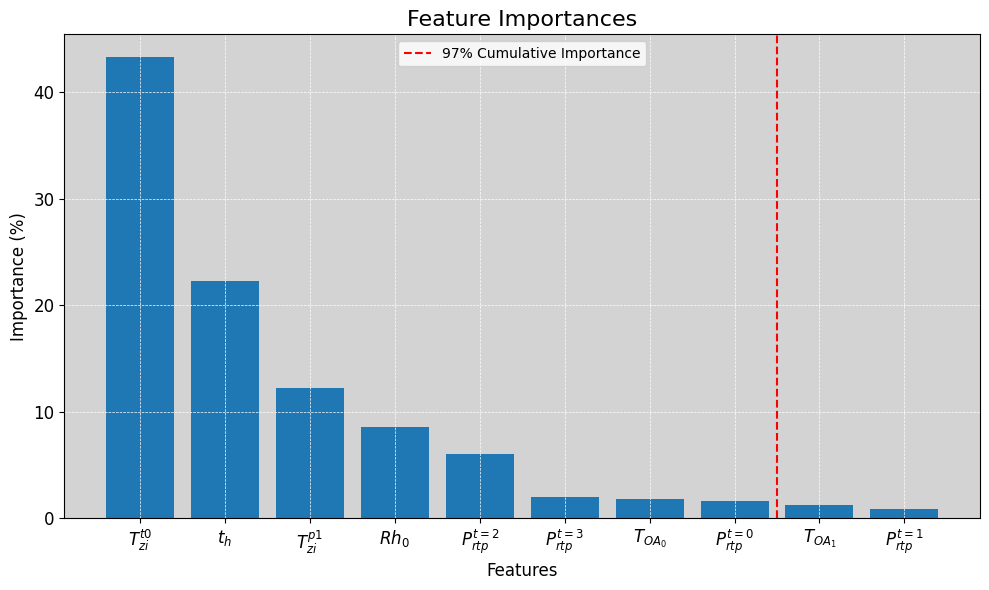

In [12]:
# Assuming you have already calculated 'importances' and have 'feature_names'
# feature_names_math = ['$T^{t0}_{zi}$', '$T^{p1}_{zi}$','$t_{h}$', '$T_{{OA}_{0}}$','$T_{{OA}_{1}}$','$T_{{RH}_{0}}$','$P^{t=0}_{rtp}$','$P^{t=1}_{rtp}$','$P^{t=2}_{rtp}$','$P^{t=3}_{rtp}$','$P^{t=4}_{rtp}$','$P^{t=5}_{rtp}$','$P^{t=6}_{rtp}$']
# feature_names = ['Temp_mean_p0','Temp_mean_m1','sen_hou','temp_OA_0','temp_OA_1','rh','rtp_0','rtp_1','rtp_2','rtp_3','rtp_4','rtp_5','rtp_6']

actual_feature_names = ['Temp_mean_p0','Temp_mean_m1','sen_hou','temp_OA_0','temp_OA_1','rh','rtp_0','rtp_1','rtp_2','rtp_3']

feature_names_math = ['$T^{t0}_{zi}$', '$T^{p1}_{zi}$','$t_{h}$', '$T_{{OA}_{0}}$','$T_{{OA}_{1}}$','${Rh}_{0}$','$P^{t=0}_{rtp}$','$P^{t=1}_{rtp}$','$P^{t=2}_{rtp}$','$P^{t=3}_{rtp}$']
feature_names = ['Temp_mean_p0','Temp_mean_m1','sen_hou','temp_OA_0','temp_OA_1','rh','rtp_0','rtp_1','rtp_2','rtp_3']
plot_feature_importances(importances_act2, feature_names_math,actual_feature_names, title_fontsize=16, label_fontsize=12, tick_fontsize=12,cutoff_percentage=0.97)

In [13]:
# Assuming you have already calculated 'importances' and have 'feature_names'
feature_names = ['Temp_mean_p0','Temp_mean_m1','sen_hou','rh','temp_OA_0','rtp_0','rtp_2','rtp_3']
feature_names_math = ['$T^{t0}_{zi}$', '$T^{p1}_{zi}$','$t_{h}$','$Rh_{0}$', '$T_{{OA}_{0}}$','$P^{t=0}_{rtp}$','$P^{t=2}_{rtp}$','$P^{t=3}_{rtp}$']

X= df[feature_names]
y_act2= df[['action_2']]
y_act1= df[['action_1']]


tree_regressor_act2 = DecisionTreeRegressor(
    max_depth=13,           # Maximum depth of the tree
    min_samples_split=3,   # Minimum number of samples required to split an internal node
    min_samples_leaf=1,
    # splitter = 'best',
    # max_features = "sqrt",
    criterion = 'squared_error',   # Minimum number of samples required to be at a leaf node
    # min_impurity_decrease = 0.000001,
)  

# Fit the model to the training data
tree_regressor_act2.fit(X, y_act2)

print ("completed training 1")

# Fit the model to the training data
tree_regressor_act1.fit(X, y_act1)


y_pred_act1 = tree_regressor_act1.predict(X)
y_pred_act2 = tree_regressor_act2.predict(X)

mse_act1 = mean_squared_error(y_act1, y_pred_act1)
mse_act2 = mean_squared_error(y_act2, y_pred_act2)

mae_act1 = mean_absolute_error(y_act1, y_pred_act1)
mae_act2 = mean_absolute_error(y_act2, y_pred_act2)

print (mse_act1)
print (mse_act2)
print ()

print (mae_act1)
print (mae_act2)

joblib.dump(tree_regressor_act1, 'tree_regressor_act1.pkl')
joblib.dump(tree_regressor_act2, 'tree_regressor_act2.pkl')


completed training 1
1.4415990163450847
0.8295923237521141

0.7636635008192578
0.501696471860608


['tree_regressor_act2.pkl']

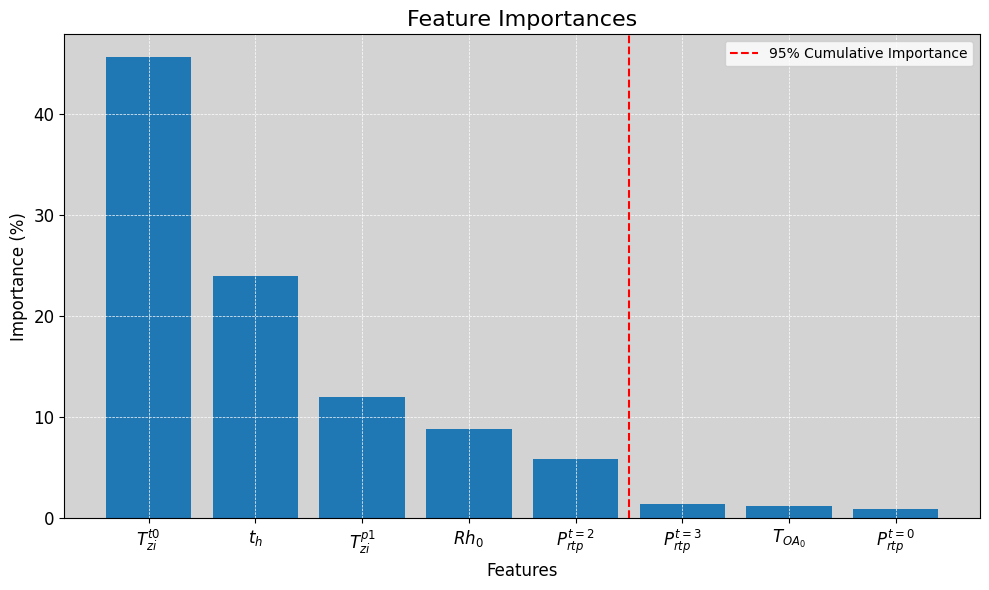

In [15]:
from sklearn.tree import DecisionTreeRegressor, plot_tree

# Now, let's apply cost complexity pruning
path = tree_regressor_act2.cost_complexity_pruning_path(X, y_act2)
alphas = path.ccp_alphas[0:100]
regrs = []



In [ ]:
cv_scores_mean = []
cv_scores_std = []
r2_scores = {}
cnt = 1 
for alpha in alphas:
    print (cnt)
    regr = DecisionTreeRegressor(
            max_depth=13,           # Maximum depth of the tree
            min_samples_split=3,   # Minimum number of samples required to split an internal node
            min_samples_leaf=1,
            # splitter = 'best',
            # max_features = "sqrt",
            criterion = 'squared_error',   # Minimum number of samples required to be at a leaf node
            # min_impurity_decrease = 0.000001,
            ccp_alpha=alpha)
    cv_scores = cross_val_score(regr, X, y_act2, cv=5, scoring='r2')
    cv_scores_mean.append(np.mean(cv_scores))
    cv_scores_std.append(np.std(cv_scores))
    r2_scores[alpha] = np.mean(cv_scores)
    cnt+=1 


# Plot the cross-validated R-squared scores against alpha values
plt.figure(figsize=(10, 6))
plt.errorbar(alphas, cv_scores_mean, yerr=cv_scores_std, marker='o', linestyle='-')
plt.title('Cross-Validated R-squared vs. Alpha for Pruning')
plt.xlabel('Alpha')
plt.ylabel('Cross-Validated R-squared')
plt.grid(True)
plt.show()

In [19]:
best_alpha = max(r2_scores, key=r2_scores.get)

0.8295937704515156

0.5017152460377206


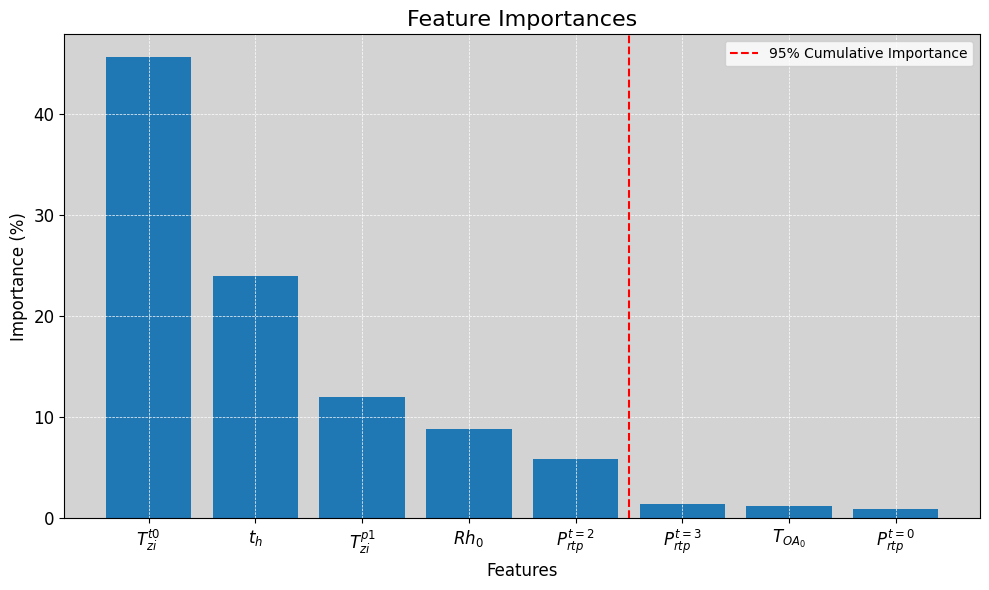

['tree_regressor_act2.pkl']

In [28]:
tree_regressor_act2 = DecisionTreeRegressor(
            max_depth=13,           # Maximum depth of the tree
            min_samples_split=3,   # Minimum number of samples required to split an internal node
            min_samples_leaf=1,
            # splitter = 'best',
            # max_features = "sqrt",
            criterion = 'squared_error',   # Minimum number of samples required to be at a leaf node
            # min_impurity_decrease = 0.000001,
            ccp_alpha=best_alpha)

tree_regressor_act2.fit(X, y_act2)


y_pred_act2 = tree_regressor_act2.predict(X)

mse_act2 = mean_squared_error(y_act2, y_pred_act2)

mae_act2 = mean_absolute_error(y_act2, y_pred_act2)

print (mse_act2)
print ()
print (mae_act2)


importances_act2 = tree_regressor_act2.feature_importances_

plot_feature_importances(importances_act2, feature_names_math,feature_names, title_fontsize=16, label_fontsize=12, tick_fontsize=12,cutoff_percentage=0.95)

joblib.dump(tree_regressor_act2, 'tree_regressor_act2.pkl')

In [62]:
feature_names = ['Temp_mean_p0','Temp_mean_m1','sen_hou','rh','rtp_2']
feature_names_math = ['$T^{t0}_{zi}$', '$T^{p1}_{zi}$','$t_{h}$','$Rh_{0}$','$P^{t=2}_{rtp}$',]


X= df[feature_names]
y_act2= df[['action_2']]
y_act1= df[['action_1']]

tree_regressor_act2 = DecisionTreeRegressor(
            max_depth=5,           # Maximum depth of the tree
            min_samples_split=3,   # Minimum number of samples required to split an internal node
            min_samples_leaf=1,
            # splitter = 'best',
            # max_features = "sqrt",
            criterion = 'squared_error',   # Minimum number of samples required to be at a leaf node
            # min_impurity_decrease = 0.000001,
            ccp_alpha=best_alpha)

tree_regressor_act2.fit(X, y_act2)

y_pred_act2 = tree_regressor_act2.predict(X)

mse_act2 = mean_squared_error(y_act2, y_pred_act2)
mae_act2 = mean_absolute_error(y_act2, y_pred_act2)

print (mse_act2)
print ()
print (mae_act2)

2.818954591283905

1.1260242646889658


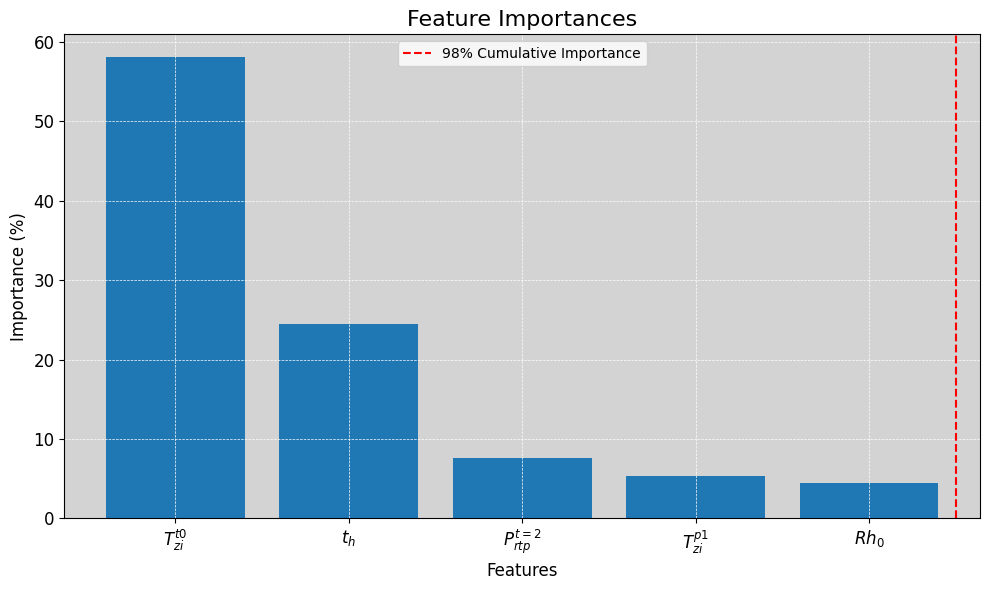

In [56]:
importances_act2 = tree_regressor_act2.feature_importances_

actual_feature_names = ['Temp_mean_p0','Temp_mean_m1','sen_hou','temp_OA_0','rtp_1','rtp_2']
plot_feature_importances(importances_act2, feature_names_math,actual_feature_names, title_fontsize=16, label_fontsize=12, tick_fontsize=12,cutoff_percentage=0.98)






In [155]:
def get_rules(tree, feature_names, class_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]
    paths = []
    path = []
    
    def recurse(node, path, paths):
        
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            p1, p2 = list(path), list(path)
            p1 += [f"({name} <= {np.round(threshold, 3)})"]
            recurse(tree_.children_left[node], p1, paths)
            p2 += [f"({name} > {np.round(threshold, 3)})"]
            recurse(tree_.children_right[node], p2, paths)
        else:
            path += [(tree_.value[node], tree_.n_node_samples[node])]
            paths += [path]
            
    recurse(0, path, paths)

    # sort by samples count
    samples_count = [p[-1][1] for p in paths]
    ii = list(np.argsort(samples_count))
    paths = [paths[i] for i in reversed(ii)]
    
    rules = []
    for path in paths:
        rule = "if "
        
        for p in path[:-1]:
            if rule != "if ":
                rule += " and "
            rule += str(p)
        rule += " then "
        if class_names is None:
            rule += "response: "+str(np.round(path[-1][0][0][0],3))
        else:
            classes = path[-1][0][0]
            l = np.argmax(classes)
            rule += f"class: {class_names[l]} (proba: {np.round(100.0*classes[l]/np.sum(classes),2)}%)"
        rule += f" | based on {path[-1][1]:,} samples"
        rules += [rule]
        
    return rules

In [ ]:
rules = get_rules(tree_regressor_act2,feature_names, ['action_2'])
for r in rules:
    print ()
    print(r)

In [157]:
def get_regression_rules_hier(tree, feature_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]

    def recurse(node):
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            left = recurse(tree_.children_left[node])
            right = recurse(tree_.children_right[node])
            return {f"{name} <= {np.round(threshold, 3)}": left, 
                    f"{name} > {np.round(threshold, 3)}": right}
        else:
            return f"predicted value: {np.round(tree_.value[node][0][0], 3)} | samples: {tree_.n_node_samples[node]}"

    return recurse(0)

In [42]:
def get_regression_rules(tree, feature_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]

    paths = []
    path = []
    
    def recurse(node, path, paths):
        
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            p1, p2 = list(path), list(path)
            p1 += [f"({name} <= {np.round(threshold, 3)})"]
            recurse(tree_.children_left[node], p1, paths)
            p2 += [f"({name} > {np.round(threshold, 3)})"]
            recurse(tree_.children_right[node], p2, paths)
        else:
            path += [(tree_.value[node], tree_.n_node_samples[node])]
            paths += [path]
            
    recurse(0, path, paths)

    # sort by samples count
    samples_count = [p[-1][1] for p in paths]
    ii = list(np.argsort(samples_count))
    paths = [paths[i] for i in reversed(ii)]
    
    rules = []
    for path in paths:
        rule = "if "
        
        for p in path[:-1]:
            if rule != "if ":
                rule += " and "
            rule += str(p)
        rule += " then "
        
        # Here's where we change for regression value:
        predicted_value = path[-1][0][0][0]
        rule += f"predicted value: {np.round(predicted_value, 3)}"

        rule += f" | based on {path[-1][1]:,} samples"
        rules += [rule]
        
    return rules

In [ ]:
rules = get_regression_rules(tree_regressor_act2,feature_names)
for r in rules:
    print ()
    print(r)

In [46]:
rules

with open("rules.txt", "w") as file:
    for item in rules:
        file.write("%s\n" % item)

len(rules)

11945

In [40]:
get_regression_rules_hier(tree_regressor_act2, feature_names)

NameError: name 'get_regression_rules_hier' is not defined

In [63]:
def tree_to_text(tree, feature_names, save_to_file=None):
    tree_ = tree.tree_
    
    def recurse(node, depth):
        indent = "    " * depth
        text = ""
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            feature_name = feature_names[tree_.feature[node]]
            threshold = tree_.threshold[node]
            text += f"{indent}if {feature_name} <= {np.round(threshold, 3)}:\n"
            text += recurse(tree_.children_left[node], depth + 1)
            text += f"{indent}else:\n"
            text += recurse(tree_.children_right[node], depth + 1)
        else:
            predicted_value = tree_.value[node][0][0]
            text += f"{indent}return {np.round(predicted_value, 3)}\n"
        return text

    result_text = recurse(0, 1)
    
    # Save the generated text to a file if a filename is provided
    if save_to_file:
        with open(save_to_file, "w") as file:
            file.write(result_text)

    return result_text

In [64]:
text_rules = tree_to_text(tree_regressor_act2,feature_names, save_to_file="tree_rules.txt")
# latex_tree = to_math_mode(text_rules)
print(text_rules)
# print(text_rules)

    if Temp_mean_p0 <= 24.427:
        if rtp_2 <= 0.15:
            if rh <= 55.0:
                if Temp_mean_p0 <= 20.583:
                    if sen_hou <= 20.4:
                        return 23.537
                    else:
                        return 24.738
                else:
                    if Temp_mean_p0 <= 23.682:
                        return 25.478
                    else:
                        return 24.249
            else:
                if sen_hou <= 6.0:
                    if Temp_mean_p0 <= 20.215:
                        return 26.662
                    else:
                        return 28.197
                else:
                    if Temp_mean_m1 <= 24.009:
                        return 24.628
                    else:
                        return 26.155
        else:
            if Temp_mean_p0 <= 23.315:
                if Temp_mean_m1 <= 26.08:
                    if Temp_mean_p0 <= 20.5:
                        return 23.965
         

In [60]:
text_rules = tree_to_text(tree_regressor_act2,feature_names)


print (text_rules) 

    if Temp_mean_p0 <= 24.427:
        if rtp_2 <= 0.15:
            if rh <= 55.0:
                if Temp_mean_p0 <= 20.583:
                    if sen_hou <= 20.4:
                        return 23.537
                    else:
                        return 24.738
                else:
                    if Temp_mean_p0 <= 23.682:
                        return 25.478
                    else:
                        return 24.249
            else:
                if sen_hou <= 6.0:
                    if Temp_mean_p0 <= 20.215:
                        return 26.662
                    else:
                        return 28.197
                else:
                    if Temp_mean_m1 <= 24.009:
                        return 24.628
                    else:
                        return 26.155
        else:
            if Temp_mean_p0 <= 23.315:
                if Temp_mean_m1 <= 26.08:
                    if Temp_mean_p0 <= 20.5:
                        return 23.965
         

In [175]:
import graphviz
import re

def visualize_tree(text):
    # Split lines and filter out empty lines
    lines = [line for line in text.split('\n') if line.strip()]

    dot = graphviz.Digraph(comment='Decision Tree', format='png')

    stack = []
    prev_indent = 0
    prev_label = None  # Initialize prev_label to ensure it has a value

    for line in lines:
        indent = len(line) - len(line.lstrip())
        line = line.strip()

        if "return" in line:
            label = re.search(r'return (.+)', line).group(1)
        else:
            label = re.search(r'if (.+):', line).group(1)

        dot.node(f"{indent}_{label}", label)

        # If indent is bigger, we add it to the stack
        if indent > prev_indent and prev_label:
            stack.append(f"{prev_indent}_{prev_label}")

        # If indent is smaller, we pop from the stack
        while stack and len(stack) * 4 > indent:
            stack.pop()

        # If there is a parent node, connect it
        if stack:
            dot.edge(stack[-1], f"{indent}_{label}")

        prev_indent = indent
        prev_label = label

    dot.view()


In [176]:
visualize_tree(text_rules)

AttributeError: 'NoneType' object has no attribute 'group'